# Word2Vec

In [1]:
import numpy as np
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url
from torchsummary import summary

from sklearn.preprocessing import OneHotEncoder

In [2]:
plt.style.use('bmh')

In [3]:
f = open("../data/song.txt", "r")
f.read()

'Hello darkness, my old friend\nI\'ve come to talk with you again\nBecause a vision softly creeping\nLeft its seeds while I was sleeping\nAnd the vision that was planted in my brain\nStill remains\nWithin the sound of silence\nIn restless dreams I walked alone\nNarrow streets of cobblestone\n\'Neath the halo of a street lamp\nI turned my collar to the cold and damp\nWhen my eyes were stabbed by the flash of a neon light\nThat split the night\nAnd touched the sound of silence\nAnd in the naked light, I saw\nTen thousand people, maybe more\nPeople talking without speaking\nPeople hearing without listening\nPeople writing songs that voices never share\nAnd no one dared\nDisturb the sound of silence\n"Fools", said I, "You do not know\nSilence like a cancer grows\nHear my words that I might teach you\nTake my arms that I might reach you"\nBut my words, like silent raindrops fell\nAnd echoed\nIn the wells of silence\nAnd the people bowed and prayed\nTo the neon god they made\nAnd the sign fl

In [47]:
f = open("../data/song.txt", "r")
corpus = []
for line in f:
    corpus.append(line.lower())
f.close()
corpus

corpus = ['king is a strong man',
         'queen is a wise woman',
         'boy is a young man',
         'girl is a young woman',
         'prince is a young king',
         'princess is a young queen',
         'man is strong',
         'woman is pretty',
         'prince is a boy will be king',
         'princess is a girl will be queen']
#corpus

In [6]:
stop_words = set(stopwords.words('english')) 

In [48]:
clean_corpus = []
for sentence in corpus:
    temp = sentence.split(' ')
    temp = [w.strip().replace('"','').replace(',','') for w in temp if w not in stop_words]
    clean_corpus.append(' '.join(temp))

clean_corpus[:5]

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king']

In [49]:
words = []
for sentence in clean_corpus:
    for word in sentence.split(' '):
        words.append(word)
        
words = list(set(words))
print(len(words))

12


In [50]:
window = 2
data = []
for num, word in enumerate(words):
    for sentence in clean_corpus:
        if word in sentence.split():
            #print('\n',num, word,'->', sentence,'='*20)
            for ix, context in enumerate(sentence.split()):
                if context == word:
                    #print(ix, context)
                    neighbors = sentence.split()[max(ix - window, 0) : min(ix + window+1, len(sentence))]
                    neighbors.remove(word)
                    for neighbor in neighbors:
                        data.append([word, neighbor])

In [51]:
data = pd.DataFrame(data, columns=['input', 'context'])
data.shape

(52, 2)

In [52]:
data.head()

,input,context
0,boy,young
1,boy,man
2,boy,prince
3,boy,king
4,woman,queen


In [53]:
class WordEncoder(nn.Module):
    def __init__(self):
        super(WordEncoder, self).__init__()
        # Number of input features is 12.
        self.hidden_layer = nn.Linear(12, 3) 
        self.output_layer = nn.Linear(3, 12)
        self.softmax_gate = nn.Softmax(dim=0)

        
    def forward(self, inputs):
        x = self.hidden_layer(inputs)
        x = self.output_layer(x)
        x = self.softmax_gate(x)

        return x

In [54]:
device = torch.device("cpu")
print(device)

cpu


In [55]:
model = WordEncoder()
model.to(device)
print(model)

WordEncoder(
  (hidden_layer): Linear(in_features=12, out_features=3, bias=True)
  (output_layer): Linear(in_features=3, out_features=12, bias=True)
  (softmax_gate): Softmax(dim=0)
)


In [56]:
print(summary(model, (1,12), device='cpu', verbose=0))
print('Parameter sizes:')
for parameter in model.parameters():
    print(parameter.shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 3]                39
├─Linear: 1-2                            [-1, 1, 12]               48
├─Softmax: 1-3                           [-1, 1, 12]               --
Total params: 87
Trainable params: 87
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
Parameter sizes:
torch.Size([3, 12])
torch.Size([3])
torch.Size([12, 3])
torch.Size([12])


## One-Hot Encoder

In [57]:
encoder = {}
dummies = pd.get_dummies(words)
for i in words:
    encoder[i] = dummies.T.loc[i].values

print(f'{words[0]}:', encoder[words[0]])
print(f'{words[1]}:', encoder[words[1]])

boy: [1 0 0 0 0 0 0 0 0 0 0 0]
woman: [0 1 0 0 0 0 0 0 0 0 0 0]


## Generate Dataset

In [58]:
X = []
Y = []
for x, y in zip(data['input'], data['context']):
    X.append(encoder[x].tolist())
    Y.append(encoder[y].tolist())

X = torch.from_numpy(np.array(X ,dtype=np.float32))
Y = torch.from_numpy(np.array(Y,dtype=np.float32))
print(f'X: {X.shape}')
print(f'Y: {Y.shape}')

X: torch.Size([52, 12])
Y: torch.Size([52, 12])


## Data Loader

In [59]:
BATCH_SIZE = 16

In [60]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(X, Y)
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

## Traning the model

In [61]:
EPOCHS = 50000
LEARNING_RATE = 0.001
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        
        loss_calc = loss(y_pred, torch.max(y_batch, 1)[1])

        
        loss_calc.backward()
        optimizer.step()
        
        epoch_loss += loss_calc.item()

        
    if e % 5000 == 0:
        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f}')
    

Epoch 5000: | Loss: 2.26409
Epoch 10000: | Loss: 2.29026
Epoch 15000: | Loss: 2.28670
Epoch 20000: | Loss: 2.27903
Epoch 25000: | Loss: 2.33154
Epoch 30000: | Loss: 2.27322
Epoch 35000: | Loss: 2.25849
Epoch 40000: | Loss: 2.28368
Epoch 45000: | Loss: 2.18259
Epoch 50000: | Loss: 2.27375


In [62]:
embedding = model.state_dict()['hidden_layer.weight'].T + model.state_dict()['hidden_layer.bias'].T
embedding[:10,:]

tensor([[-2.9153, -1.6174, -0.9299],
        [ 2.6068, -0.3059, -0.7618],
        [ 1.9018,  0.6049, -2.9335],
        [ 1.7332,  1.8250,  0.8629],
        [-0.7614, -3.0102, -4.5835],
        [-1.7445,  0.7879, -1.6937],
        [ 2.3207,  0.3810,  1.2061],
        [-1.0073, -5.1184,  2.1313],
        [-2.2504, -1.3327,  2.7722],
        [-0.5810,  3.6663, -1.2182]])

In [63]:
w2v = pd.DataFrame(embedding, columns=['x1','x2','x3'])
w2v['word'] = words
w2v = w2v[['word','x1','x2','x3']]
w2v['x1'] = w2v['x1'].apply(lambda x: x.item())
w2v['x2'] = w2v['x2'].apply(lambda x: x.item())
w2v['x3'] = w2v['x3'].apply(lambda x: x.item())
w2v.head(3)

,word,x1,x2,x3
0,boy,-2.915332,-1.617414,-0.929890
1,woman,2.606802,-0.305869,-0.761810
2,princess,1.901796,0.604899,-2.933453


## 2D Plot

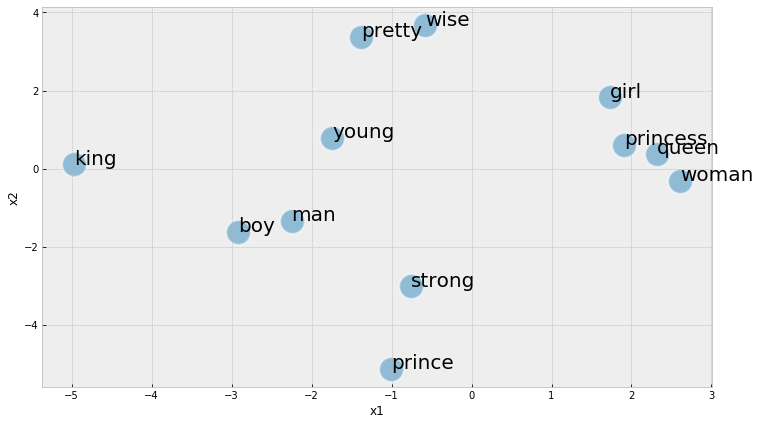

In [64]:
fig, ax = plt.subplots(figsize=(12,7))

for word, x1, x2 in zip(w2v['word'], w2v['x1'], w2v['x2']):
    ax.annotate(word, (x1, x2), size=20)
sns.scatterplot(data=w2v, x="x1", y="x2", s=600, alpha=0.5)
plt.show()

## 3D Plot

In [66]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)

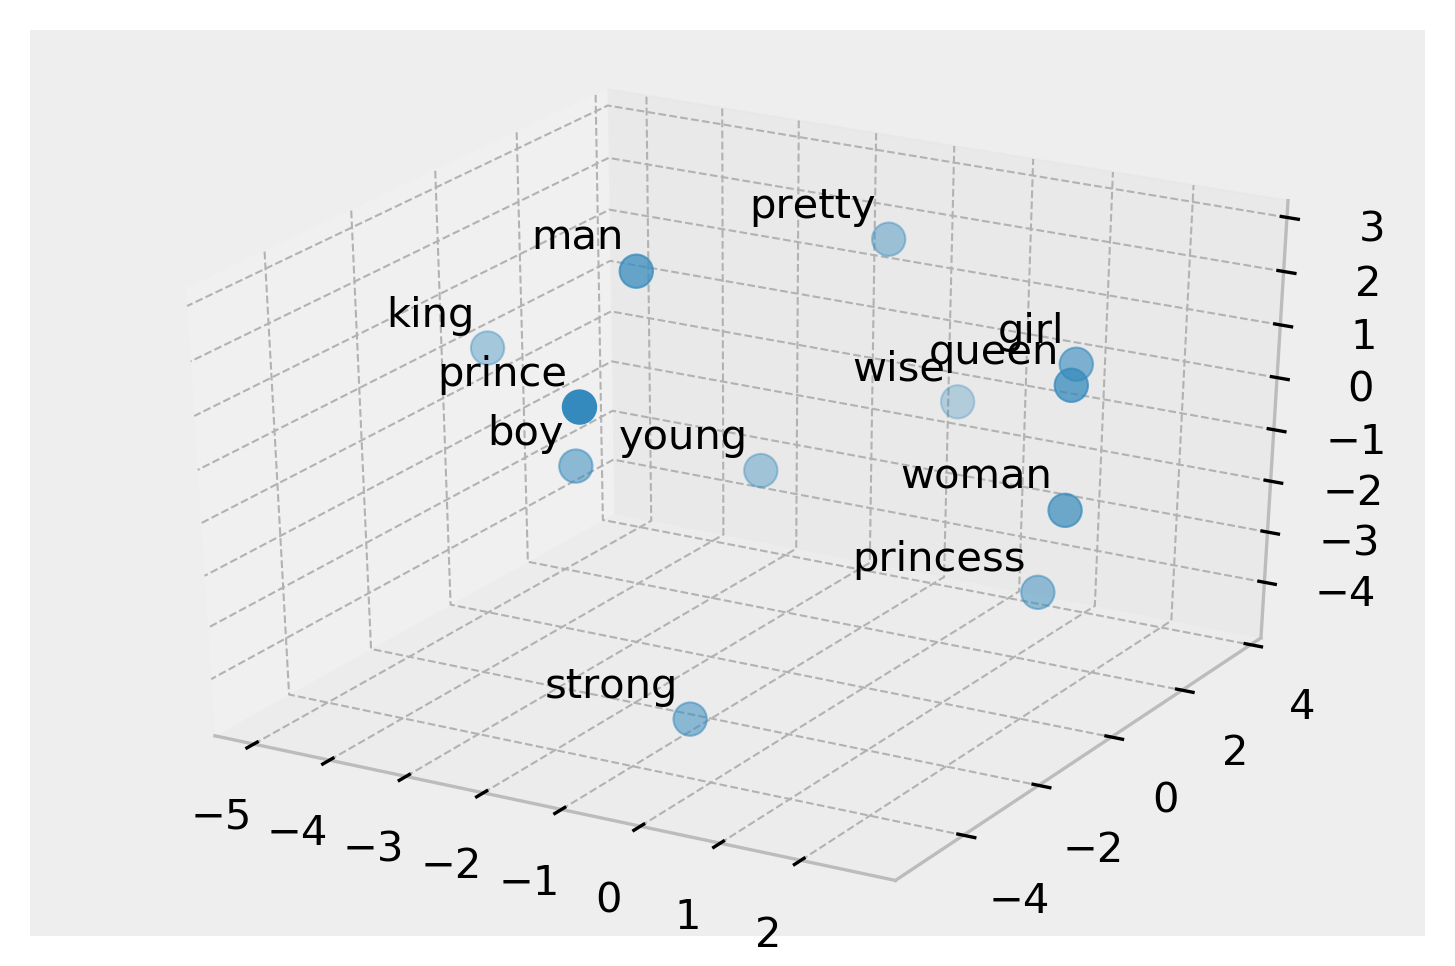

In [67]:
fig = plt.figure(dpi=300)
ax = fig.gca(projection='3d')
#ax.set_axis_off()

xyzn = zip(w2v['x1'], w2v['x2'], w2v['x3'])

ax.scatter(w2v['x1'], w2v['x2'], w2v['x3'], marker='o', s = 64)

# add vertices annotation.
for j, xyz_ in enumerate(xyzn): 
    annotate3D(ax, s=w2v['word'][j], xyz=xyz_, fontsize=10, xytext=(-3,3),
               textcoords='offset points', ha='right',va='bottom')    
plt.show()